In [1]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import glob
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings


warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code

# session lists in a .py file
# import sessionlists
%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/test.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/sequencesALLDATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [3]:
rat_markers = {}
params = {}
nb_runsBin = {}
speedRunToLeftBin, speedRunToRightBin = {}, {}
timeRunToLeftBin, timeRunToRightBin = {}, {}
maxSpeedLeftBin, maxSpeedRightBin = {}, {}
timeStayInLeftBin, timeStayInRightBin = {}, {}
totalDistance, totalWater, total_trials = {}, {}, {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}
instantSpeedLeftBin, instantSpeedRightBin = {}, {}
trackTimeToLeftBin, trackTimeToRightBin = {}, {}
sequence = {}

# # define colors for each rat
# palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
#            'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
#            'RatF20': (0.4, 0.0, 0.0), 'RatF21': (0.55, 0.13, 0.13), 'RatF22': (0.8, 0.2, 0.2),
#            'RatM20': (0.0, 0.4, 0.0), 'RatM21': (0.13, 0.55, 0.13), 'RatM22': (0.2, 0.8, 0.2),
#            'RatF30': (0.4, 0.0, 0.0), 'RatF31': (0.55, 0.13, 0.13), 'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
#            'RatM30': (0.0, 0.4, 0.0), 'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
#            'RatF30L': (0.4, 0.0, 0.0), 'RatF31L': (0.55, 0.13, 0.13), 'RatF32L': (0.8, 0.2, 0.2), 'RatF33L': (0.8, 0.2, 0.2),
#            'RatM30L': (0.0, 0.4, 0.0), 'RatM31L': (0.13, 0.55, 0.13), 'RatM32L': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}

# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
                                                #  dist60bis+dist90bis+dist120bis)):

        # get the preprocessed data from the pickle file
        # In this notebook we only need the sequence of events, so we only load that
        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

        params[animal, session]     = get_from_pickle(root, animal[0:6], session, name="params.p", biglesion=biglesion)
        nb_runsBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="nbRuns.p", biglesion=biglesion)
        speedRunToLeftBin[animal, session],  speedRunToRightBin[animal, session]  = get_from_pickle(root, animal[0:6], session, name="avgSpeed.p", biglesion=biglesion)
        maxSpeedLeftBin[animal, session],    maxSpeedRightBin[animal, session]    = get_from_pickle(root, animal[0:6], session, name="maxSpeed.p", biglesion=biglesion)
        timeStayInLeftBin[animal, session],  timeStayInRightBin[animal, session]  = get_from_pickle(root, animal[0:6], session, name="timeinZone.p", biglesion=biglesion)
        timeRunToLeftBin[animal, session],   timeRunToRightBin[animal, session]   = get_from_pickle(root, animal[0:6], session, name="timeRun.p", biglesion=biglesion)
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackPos.p", biglesion=biglesion)
        instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal[0:6], session, name="trackSpeed.p", biglesion=biglesion)
        trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackTime.p", biglesion=biglesion)
        totalDistance[animal, session],      totalWater[animal, session], total_trials[animal, session] = get_from_pickle(root, animal[0:6], session, name="misc.p", biglesion=biglesion)


Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43
Loading data for RatF50
Loading data for RatF51
Loading data for RatF52
Loading data for RatM50
Loading data for RatM51
Loading data for RatM52
Loading data for RatM53
Loading data for RatM54


In [7]:
# 2 vs-2 cm/s

data2IDLE = prepare_data_idle_times(sequence, animalList, TM2)
datarev2IDLE = prepare_data_idle_times(sequence, animalList, TMrev2)
data2RUN = prepare_data_running_times(sequence, animalList, TM2)
datarev2RUN = prepare_data_running_times(sequence, animalList, TMrev2)



alpha_t_fixed, gamma_t_fixed, alpha_U_fixed, gamma_U_fixed = False, False, False, False
mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = False, False, False, False

alpha, gamma, alpha_t, gamma_t, alpha_U, gamma_U, lossWald = {}, {}, {}, {}, {}, {}, {}
mu, mu_t, mu_U, sigma, sigma_t, sigma_U, loss = {}, {}, {}, {}, {}, {}, {}


for animal in animalList:
    print(animal)
    alpha[animal] = {"2": 0, "rev2": 0}
    gamma[animal] = {"2": 0, "rev2": 0}
    alpha_t[animal] = {"2": 0, "rev2": 0}
    gamma_t[animal] = {"2": 0, "rev2": 0}
    alpha_U[animal] = {"2": 0, "rev2": 0}
    gamma_U[animal] = {"2": 0, "rev2": 0}
    lossWald[animal] = {"2": 0, "rev2": 0}

    mu[animal] = {"2": 0, "rev2": 0}
    sigma[animal] = {"2": 0, "rev2": 0}
    mu_t[animal] = {"2": 0, "rev2": 0}
    sigma_t[animal] = {"2": 0, "rev2": 0}
    mu_U[animal] = {"2": 0, "rev2": 0}
    sigma_U[animal] = {"2": 0, "rev2": 0}
    loss[animal] = {"2": 0, "rev2": 0}


    for cond, data in zip(["2", "rev2"], [data2IDLE, datarev2IDLE]):
        (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_U[animal][cond], thetasecond, gamma_U[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                        gamma_t_fixed=gamma_t_fixed, 
                                                                                                                        alpha_R_fixed=alpha_U_fixed, 
                                                                                                                        gamma_R_fixed=gamma_U_fixed)

    for cond, data in zip(["2", "rev2"], [data2RUN, datarev2RUN]):
        (mu[animal][cond], sigma[animal][cond], \
        mu_t[animal][cond], sigma_t[animal][cond], \
        mu_U[animal][cond], sigma_U[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], f=modelrun_crit,
                                                                                      mu_t_fixed=mu_t_fixed, 
                                                                                                    sigma_t_fixed=sigma_t_fixed, 
                                                                                                    mu_R_fixed=mu_U_fixed, 
                                                                                                    sigma_R_fixed=sigma_U_fixed)
        print(mu[animal][cond], sigma[animal][cond], 
        mu_t[animal][cond], sigma_t[animal][cond], 
        mu_U[animal][cond], sigma_U[animal][cond], loss[animal][cond])

# pickle.dump([alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U,], open("picklejar/ModelsFitsAllRats.p", "wb"))

RatF00
1.2651209214944856 0.05832319438603988 0.13311393677684522 0.04572593074971926 -0.00038874580048389257 0.04895800758026516 25.054442526118592
1.3232165980465314 0.08038727561942503 0.1331748116782759 0.02885604776781401 0.015211510227673669 0.06492689665456279 24.2092945634255
RatF01
1.250202264293019 0.05788617711861165 0.09897476505706924 0.012299605866558275 0.00518364603568217 0.04554526619102926 18.787456115301197
1.2920033532008421 0.04876230296322465 0.0733037113705382 0.029851084035362904 0.010657053405887736 0.03539216588944229 15.933439897283105
RatF02
1.3416470203507513 0.0842601315103425 0.17071681405515418 0.02550956793234532 -0.07823655032929623 -0.0024631710927215207 5.586886170739481
1.431031787925236 0.13841526820738928 0.11954949800438296 0.021646757704685916 -0.08321217171674651 -0.009554108675938602 11.461323327559631
RatM00
1.4826012055524886 0.08108664204242341 0.02955851568962372 -0.004916094804418627 0.010074262011584038 0.0238291896068106 0.0716808740739

$\alpha_0$ 0.6775
$\alpha_t$ 1.0
$\alpha_U$ 0.1734
$\gamma_0$ 0.0507
$\gamma_t$ 0.0231
$\gamma_U$ 0.1857
$\mu_0$ 0.8068
$\mu_t$ 0.4811
$\mu_U$ 0.4172
$\sigma_0$ 0.3214
$\sigma_t$ 0.6896
$\sigma_U$ 0.1086
[False False False False False False False False False False False False] [1.     1.     1.     0.6084 0.2772 1.     1.     1.     1.     1.
 1.     1.    ] 0.004166666666666667


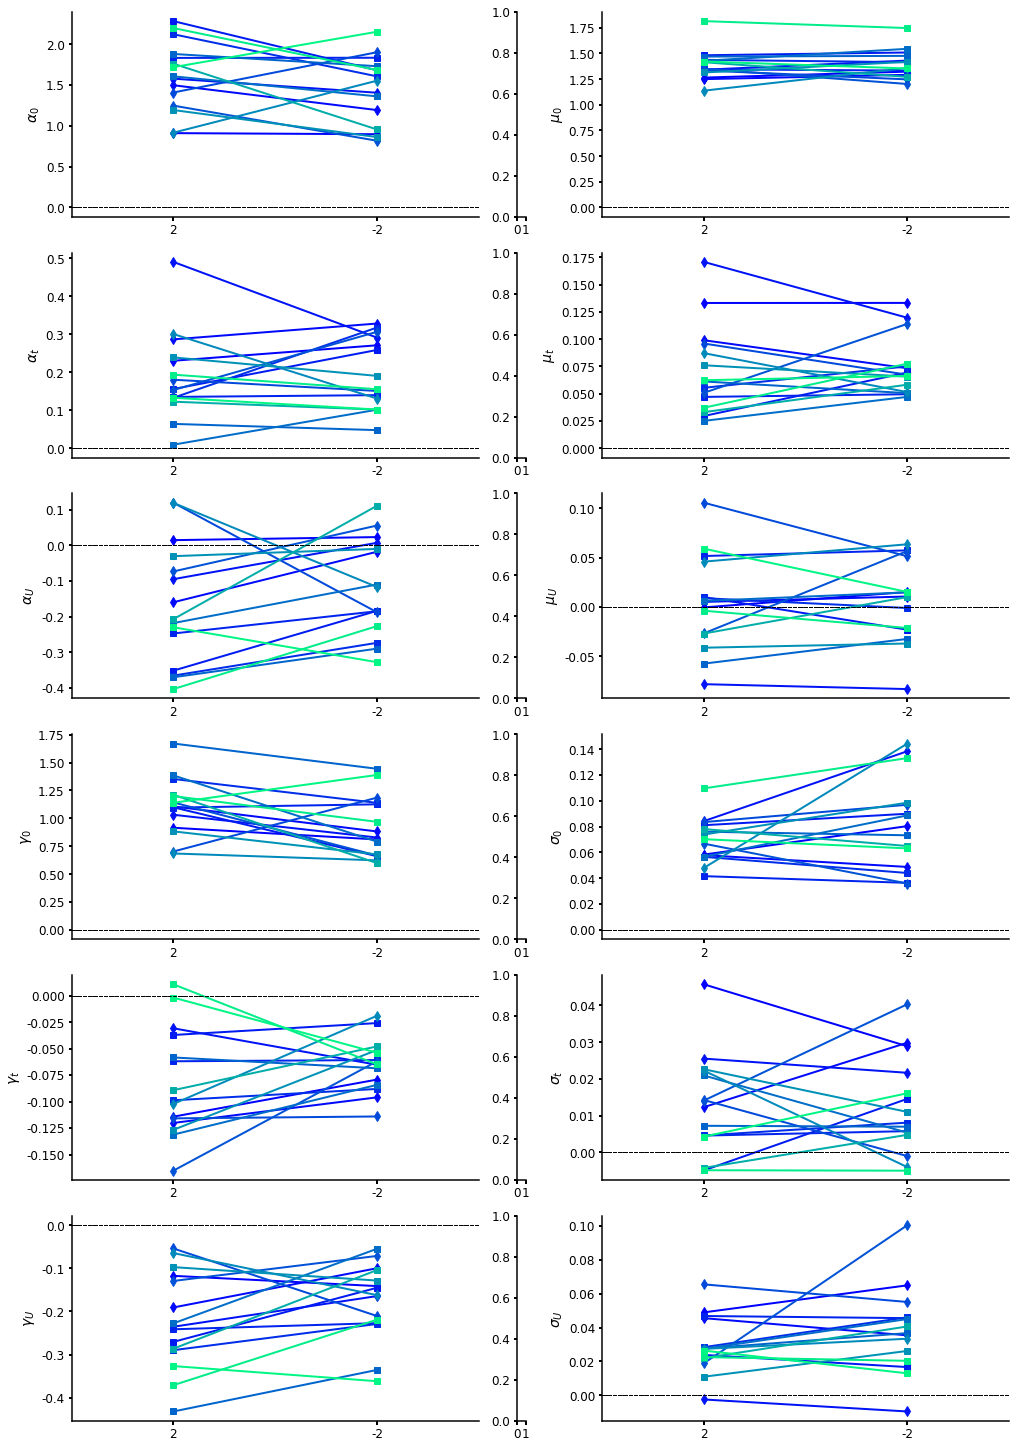

In [19]:
# 2 vs-2 cm/s
fig, axs = plt.subplots(6, 3, figsize=(14, 20), gridspec_kw={'width_ratios': [5, .1, 5]})
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_U$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_U$"]
ylimsIDLE = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_U$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_U$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .15], [-.05, .2], [-.05, .05], [-.025, .1], ]

varsIDLE = [alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U]
varsRUN = [mu, mu_t, mu_U, sigma, sigma_t, sigma_U, ]

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

pvals = []
for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
    for animal in animalList:
    
        axs[i, 0].plot([0, 1], [var[animal]["2"], var[animal]["rev2"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(2))
        axs[i, 0].set_xticklabels(["2", "-2"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 1.5)
        # axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    p = exact_mc_perm_paired_test(np.asarray([var[animal]["2"] for animal in animalList]), 
                                  np.asarray([var[animal]["rev2"] for animal in animalList]), 10000)
    print(ylabel, p)
    pvals.append(p)

for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
    for animal in animalList:
        axs[i, 2].plot([0, 1,], [var[animal]["2"], var[animal]["rev2"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks(np.arange(2))
        axs[i, 2].set_xticklabels(["2", "-2"])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, 1.5)
        # axs[i, 2].set_ylim(ylim)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)

    p = exact_mc_perm_paired_test(np.asarray([var[animal]["2"] for animal in animalList]), 
                                  np.asarray([var[animal]["rev2"] for animal in animalList]), 10000)
    print(ylabel, p)
    pvals.append(p)

sig, corrected_pvalues, alphabonf = multipletests_bonferroni(pvals, )
print(sig, corrected_pvalues, alphabonf)


In [18]:
def multipletests_bonferroni(pvals, alpha=0.05):
    pvals = np.asarray(pvals)
    sorted = np.argsort(pvals)
    pvals = np.take(pvals, sorted)

    ntests = len(pvals)
    alphacBonf = alpha / float(ntests)

    # bonferroni correction, return everything <= alphacBonf, clip pvals at 1
    reject = pvals <= alphacBonf
    pvals_corrected = np.clip(pvals * float(ntests), 0, 1)

    # reorder pvals and reject to original order of pvals
    pvals_corrected_ = np.empty_like(pvals_corrected)
    pvals_corrected_[sorted] = pvals_corrected
    reject_ = np.empty_like(reject)
    reject_[sorted] = reject

    return reject_, pvals_corrected_, alphacBonf

In [5]:
# separate the data into time and reward bins for each experimental condition
# distances 
data60IDLE = prepare_data_idle_times(sequence, animalList, dist60)
data90IDLE = prepare_data_idle_times(sequence, animalList, dist90)
data120IDLE = prepare_data_idle_times(sequence, animalList, dist120)

data60RUN = prepare_data_running_times(sequence, animalList, dist60)
data90RUN = prepare_data_running_times(sequence, animalList, dist90)
data120RUN = prepare_data_running_times(sequence, animalList, dist120)

# treadmill speeds
data20IDLE = prepare_data_idle_times(sequence, animalList, TM20)
data10IDLE = prepare_data_idle_times(sequence, animalList, TM10)
data2IDLE = prepare_data_idle_times(sequence, animalList, TM2+TMrev2)
datarev10IDLE = prepare_data_idle_times(sequence, animalList, TMrev10)
datarev20IDLE = prepare_data_idle_times(sequence, animalList, TMrev20)

data20RUN = prepare_data_running_times(sequence, animalList, TM20)
data10RUN = prepare_data_running_times(sequence, animalList, TM10)
data2RUN = prepare_data_running_times(sequence, animalList, TM2+TMrev2)
datarev10RUN = prepare_data_running_times(sequence, animalList, TMrev10)
datarev20RUN = prepare_data_running_times(sequence, animalList, TMrev20)

# all conditions pooled
dataAllIDLE = prepare_data_idle_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)
dataAllRUN = prepare_data_running_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)


In [79]:
# separate the data into time and reward bins for each experimental condition


data60RUN = prepare_data_running_times(sequence, animalList, dist60, memsize=1)
data90RUN = prepare_data_running_times(sequence, animalList, dist90, memsize=1)
data120RUN = prepare_data_running_times(sequence, animalList, dist120, memsize=1)

# treadmill speeds
data20RUN = prepare_data_running_times(sequence, animalList, TM20, memsize=1)
data10RUN = prepare_data_running_times(sequence, animalList, TM10, memsize=1)
data2RUN = prepare_data_running_times(sequence, animalList, TM2+TMrev2, memsize=1)
datarev10RUN = prepare_data_running_times(sequence, animalList, TMrev10, memsize=1)
datarev20RUN = prepare_data_running_times(sequence, animalList, TMrev20, memsize=1)

dataAllRUN = prepare_data_running_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, memsize=1)

In [249]:
modelrun_fit(datarev10RUN['RatM30'], N_avg=4)

(array([1.82878427, 0.13623717, 0.11118679, 0.05090228, 0.04990036,
        0.00347531]),
 16.942966425755493)

In [231]:
modelrun_fit(datarev10RUN['RatM30'], N_avg=4)

(array([1.86352664, 0.14034178, 0.09391711, 0.04158679, 0.03999522,
        0.00953296]),
 1042.197352205256)

In [152]:
def crit_cauchy(params, *args, robustness_param=1e-20):
    """negative log likelihood function for Cauchy distribution"""
    mu, sigma = params
    x = args
    pdf_vals = stats.cauchy.pdf(x, loc=mu, scale=sigma) + robustness_param
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val


def cauchy_fit(x, mu_init=1, sigma_init=.1):
    """fit Cauchy distribution"""
    params_init = np.array([mu_init, sigma_init])
    res = minimize(crit_cauchy, params_init, args=x, bounds=((0, None), (1e-8, None)))
    return res.x


cauchy_fit(datarev10RUN['RatM30'][0][0])

array([1.86701127, 0.14160449])

In [146]:
%timeit cauchy_fit(datarev10RUN['RatM30'][0][0])
%timeit stats.cauchy.fit(datarev10RUN['RatM30'][0][0])
%timeit fast_cauchy_fit(datarev10RUN['RatM30'][0][0])

12.1 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.82 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
237 µs ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [142]:
print(fast_cauchy_fit(datarev10RUN['RatM30'][0][0]))
print(stats.cauchy.fit(datarev10RUN['RatM30'][0][0]))
print(np.median(datarev10RUN['RatM30'][0][0]), np.std(datarev10RUN['RatM30'][0][0]))

[1.86701127 0.14160449]
(1.867046521338513, 0.1416200948867451)
1.8799999999999955 0.26223984702157926


In [154]:
def fast_cauchy_fit(data):
    median = np.median(data)
    scale = np.percentile(data, 75) - np.percentile(data, 25)
    return median, scale/2

def modelrun_fit(data, init=[1.7, 0.2, 0.2, 0.02, 0.0, 0], f=modelrun_crit,
                 N_bins=6, N_avg=4, N_params=2,
                 mu_t_fixed=False, sigma_t_fixed=False,
                 mu_U_fixed=False, sigma_U_fixed=False):
    params_init = np.array(init)
    mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
    sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
    mu_U_bounds = (None, None) if not mu_U_fixed else (0, 1e-8)
    sigma_U_bounds = (None, None) if not sigma_U_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
                   bounds=((None, None), (0, None),
                           mu_t_bounds, sigma_t_bounds,
                           mu_U_bounds, sigma_U_bounds))
    return res.x, res.fun

def modelrun_crit(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    l = 0
    N = 0
    N_bins, N_avg = args[1]
    N_params = args[2]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg]  # if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            if len(args[0][bin][avg]) > 0:

                # fit_mu, fit_sigma = stats.cauchy.fit(args[0][bin][avg])
                # fit_mu, fit_sigma = fast_cauchy_fit(args[0][bin][avg])
                fit_mu, fit_sigma = fast_cauchy_fit(args[0][bin][avg])
                loss_mu = (_mu - fit_mu)**2
                loss_sigma = (_sigma - fit_sigma)**2
                l += (loss_mu + loss_sigma)

                # n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
                # N += n
                N += 1

            else:
                pass

    k = N_params
    BIC_RSS = N * np.log(l/N) + k * np.log(N)
    return BIC_RSS

modelrun_fit(datarev10RUN['RatM30'], N_avg=4, f=modelrun_crit)

(array([ 1.80161863,  0.2194593 ,  0.17853704,  0.02247522,  0.01888423,
        -0.02010655]),
 -56.41422001621202)

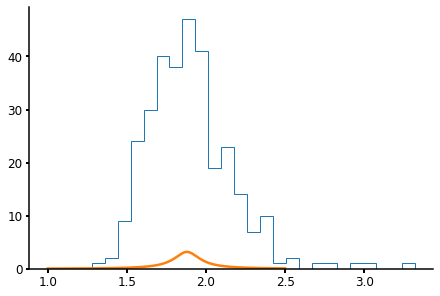

In [83]:
plt.hist(datarev10RUN['RatM30'][0][0], bins=25, histtype='step')
x = np.linspace(1, 2.5, 1000)
y = stats.cauchy.pdf(x, loc=1.88, scale=.1)
plt.plot(x,y)

(1.867046521338513, 0.1416200948867451)


(array([0.03915304, 0.07830608, 0.35237737, 0.93967299, 1.17459124,
        1.56612166, 1.48781557, 1.84019295, 1.6052747 , 0.74390779,
        0.90051995, 0.54814258, 0.27407129, 0.39153041, 0.03915304,
        0.07830608, 0.        , 0.03915304, 0.03915304, 0.        ,
        0.03915304, 0.03915304, 0.        , 0.        , 0.03915304]),
 array([1.28  , 1.3616, 1.4432, 1.5248, 1.6064, 1.688 , 1.7696, 1.8512,
        1.9328, 2.0144, 2.096 , 2.1776, 2.2592, 2.3408, 2.4224, 2.504 ,
        2.5856, 2.6672, 2.7488, 2.8304, 2.912 , 2.9936, 3.0752, 3.1568,
        3.2384, 3.32  ]),
 [<matplotlib.patches.Polygon at 0x7fc7bc10d6d0>])

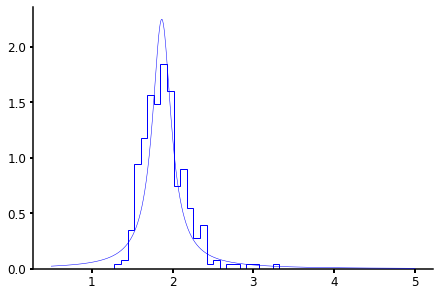

In [90]:
x = np.linspace(0.5, 5, 1000)
p = stats.cauchy.fit(datarev10RUN['RatM30'][0][0])
print(p)
y = stats.cauchy.pdf(x, *p)
plt.plot(x, y, color=plt.get_cmap('winter')(0), zorder=4, lw=0.5)
plt.hist(datarev10RUN['RatM30'][0][0], bins=25, histtype='step', density=True, color=plt.get_cmap('winter')(0))

In [124]:
def modelrun_fit_median(data, init=[1.56, 0, 0.05, 0, 0.048, 0], f=modelrun_crit,
                 N_bins=6, N_avg=4, N_params=2,
                 mu_t_fixed=False, sigma_t_fixed=False,
                 mu_U_fixed=False, sigma_U_fixed=False):
    params_init = np.array(init)
    mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
    sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
    mu_U_bounds = (None, None) if not mu_U_fixed else (0, 1e-8)
    sigma_U_bounds = (None, None) if not sigma_U_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
                   bounds=((None, None), (0, None),
                           mu_t_bounds, sigma_t_bounds,
                           mu_U_bounds, sigma_U_bounds))
    return res.x, res.fun


# def modelrun_crit_median(params, *args, robustness_param=1e-20):
#     mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
#     l = 0
#     N_bins, N_avg = args[1]
#     MU = np.zeros((N_bins, N_avg))
#     SIGMA = np.zeros((N_bins, N_avg))

#     for bin in range(N_bins):
#         for avg in range(N_avg):
#             MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
#             SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

#     for bin in range(N_bins):
#         for avg in range(N_avg):
#             _mu = MU[bin, avg]  # if MU[bin, avg] > 0 else 1e-8
#             _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

#             if len(args[0][bin][avg]) > 0:
#                 loss_mu = (_mu - np.nanmedian(args[0][bin][avg]))**2
#                 loss_sigma = (_sigma - np.nanstd(args[0][bin][avg]))**2
#             else:
#                 loss = 0  # 1e-8
#             # n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
#             l += (loss_mu + loss_sigma)
#     return l

def modelrun_crit_median(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    l = 0
    N = 0
    N_bins, N_avg = args[1]
    N_params = args[2]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg]  # if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            if len(args[0][bin][avg]) > 0:
                loss_mu = (_mu - np.nanmedian(args[0][bin][avg]))**2
                loss_sigma = (_sigma - np.nanstd(args[0][bin][avg]))**2
                l += (loss_mu + loss_sigma)

                # n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
                N += 1

            else:
                pass

    k = N_params
    BIC_RSS = N * np.log(l/N) + k * np.log(N)
    return BIC_RSS

# def modelrun_compare_median(params, *args, robustness_param=1e-20):
#     """BIC to compare models with different number of parameters and curves"""
#     mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
#     l = 0
#     N = 0
#     N_bins, N_avg = args[1]
#     N_params = args[2]
#     MU = np.zeros((N_bins, N_avg))
#     SIGMA = np.zeros((N_bins, N_avg))

#     for bin in range(N_bins):
#         for avg in range(N_avg):
#             MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
#             SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

#     for bin in range(N_bins):
#         for avg in range(N_avg):
#             _mu = MU[bin, avg]# if MU[bin, avg] > 0 else 1e-8
#             _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

#             if len(args[0][bin][avg]) > 0:
#                 loss = (_mu - np.nanmedian(args[0][bin][avg]))**2
#                 # loss += (_sigma - np.nanstd(args[0][bin][avg]))**2
#             else:
#                 loss = 0#1e-8
#             n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
#             l += loss
#             N += n

#     k = N_params
#     BIC_RSS = N * np.log(l/N) + k * np.log(N)
#     return BIC_RSS


# def modelrun_compare_median(params, *args, robustness_param=1e-20):
#     mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
#     sum_log_likelihood = 0
#     N = 0
#     N_bins, N_avg = args[1]
#     N_params = args[2]
#     MU = np.zeros((N_bins, N_avg))
#     SIGMA = np.zeros((N_bins, N_avg))

#     for bin in range(N_bins):
#         for avg in range(N_avg):
#             MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
#             SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

#     for bin in range(N_bins):
#         for avg in range(N_avg):
#             _mu = MU[bin, avg]# if MU[bin, avg] > 0 else 1e-8
#             _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

#             pdf_vals = stats.cauchy.pdf(args[0][bin][avg], loc=_mu, scale=_sigma)
#             ln_pdf_vals = np.log(pdf_vals + robustness_param)
#             log_lik_val = ln_pdf_vals.sum()

#             n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1

#             N += n
#             sum_log_likelihood += log_lik_val

#     neg_log_likelihood = -sum_log_likelihood
#     # k = N_params
#     # BIC = k * np.log(N) - 2 * neg_log_likelihood
#     return neg_log_likelihood

In [245]:
def modelrun_crit(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg]# if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            pdf_vals = stats.cauchy.pdf(args[0][bin][avg], scale=_sigma, loc=_mu,)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            neg_log_lik_val += (-log_lik_val / n)
            # neg_log_lik_val += -log_lik_val
            # except:
            #     neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val


def modelrun_compare(params, *args, robustness_param=1e-20):
    """BIC to compare models with different number of parameters and curves"""
    mu, sigma, mu_t, sigma_t, mu_U, sigma_U = params
    BIC = 0
    N = 0
    sum_log_likelihood = 0

    N_bins, N_avg = args[1]
    N_params = args[2]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_t + avg*mu_U
            SIGMA[bin, avg] = sigma + bin*sigma_t + avg*sigma_U

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg] if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8
            # try:
            pdf_vals = stats.cauchy.pdf(args[0][bin][avg], loc=_mu, scale=_sigma)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1

            N += n
            sum_log_likelihood += log_lik_val

    k = N_params
    BIC = k * np.log(N) - 2 * sum_log_likelihood
    return BIC


def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1], f=modelrun_crit,
                 N_bins=6, N_avg=4, N_params=2,
                 mu_t_fixed=False, sigma_t_fixed=False,
                 mu_U_fixed=False, sigma_U_fixed=False):
    params_init = np.array(init)
    mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
    sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
    mu_U_bounds = (None, None) if not mu_U_fixed else (0, 1e-8)
    sigma_U_bounds = (None, None) if not sigma_U_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
                   bounds=((None, None), (None, None),
                           mu_t_bounds, sigma_t_bounds,
                           mu_U_bounds, sigma_U_bounds))
    return res.x, res.fun


4.4646464646464645


Text(0, 0.5, '$\\Sigma$ loss, norm')

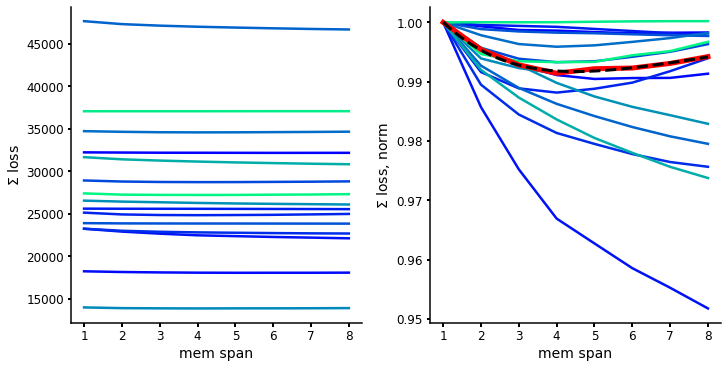

In [295]:
memsizes = np.arange(1, 9)


history_losses = {k:np.zeros(len(memsizes)) for k in intact}
normalized_history_losses = {k:np.zeros(len(memsizes)) for k in intact}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

if os.path.exists("picklejar/rewardHistoryLossCrossingTime.p"):
    history_losses = pickle.load(open("picklejar/rewardHistoryLossCrossingTime.p", "rb"))
else:
    for idx, memsize in enumerate(memsizes):
        print(f'Running for memsize {memsize}')
        data_all = prepare_data_running_times(sequence, intact, sessions, memsize=memsize, time_bins=6)
        for animal in intact:
            p, history_losses[animal][idx] = modelrun_fit(data_all[animal], f=modelrun_compare, N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for idx, animal in enumerate(intact):
    axs[0].plot(memsizes, history_losses[animal], color=rat_markers[animal][0])
    axs[1].plot(memsizes, (history_losses[animal])/(history_losses[animal][0]), color=rat_markers[animal][0], label=animal)
    normalized_history_losses[animal] = (history_losses[animal])/(history_losses[animal][0])


median_losses = np.median(np.array(list(normalized_history_losses.values())), axis=0)
axs[1].plot(memsizes, median_losses, color='r', lw=5)
z = np.poly1d(np.polyfit(memsizes, median_losses, 4))
x=np.linspace(1, 8, 100)
axs[1].plot(x, z(x), color='k', lw=3, ls='--')
print(x[np.argmin(z(x))])


# median_losses_females = np.median([normalized_history_losses[animal] for animal in intact if fnmatch.fnmatch(animal, 'RatF*')], axis=0)
# median_losses_males = np.median([normalized_history_losses[animal] for animal in intact if fnmatch.fnmatch(animal, 'RatM*')], axis=0)
# axs[1].plot(memsizes, median_losses_females, color='r', lw=2, ls='--')
# axs[1].plot(memsizes, median_losses_males, color='g', lw=2, ls='--')

axs[0].set_xlabel('mem span')
axs[1].set_xlabel('mem span')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')

# pickle.dump(history_losses, open("picklejar/rewardHistoryLossCrossingTime.p", "wb"))

3.404040404040404


Text(0, 0.5, '$\\Sigma$ loss, norm')

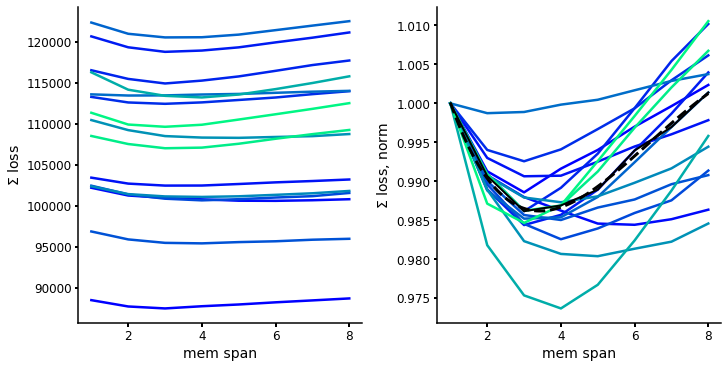

In [291]:
memsizes = np.arange(1, 9)

losses = {k:np.zeros(len(memsizes)) for k in intact}
normalized_losses = {k:np.zeros(len(memsizes)) for k in intact}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

if os.path.exists("picklejar/rewardHistoryLossIdleTime.p"):
    losses = pickle.load(open("picklejar/rewardHistoryLossIdleTime.p", "rb"))
else:
    for idx, memsize in enumerate(memsizes):
        data_all = prepare_data_idle_times(sequence, intact, sessions, memsize=memsize, time_bins=6)
        for animal in intact:
            p, losses[animal][idx] = modelwald_fit(data_all[animal], f=model_compare, N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for idx, animal in enumerate(intact):
    axs[0].plot(memsizes, losses[animal], color=rat_markers[animal][0])
    axs[1].plot(memsizes, (losses[animal])/(losses[animal][0]), color=rat_markers[animal][0], label=animal)
    normalized_losses[animal] = (losses[animal])/(losses[animal][0])

median_losses = np.median(np.array(list(normalized_losses.values())), axis=0)
axs[1].plot(memsizes, median_losses, color='k', lw=2)
z = np.poly1d(np.polyfit(memsizes, median_losses, 4))
x=np.linspace(1, 8, 100)
axs[1].plot(x, z(x), color='k', lw=3, ls='--')
print(x[np.argmin(z(x))])


# median_losses_females = np.median([normalized_losses[animal] for animal in intact if fnmatch.fnmatch(animal, 'RatF*')], axis=0)
# median_losses_males = np.median([normalized_losses[animal] for animal in intact if fnmatch.fnmatch(animal, 'RatM*')], axis=0)
# axs[1].plot(memsizes, median_losses_females, color='r', lw=2, ls='--')
# axs[1].plot(memsizes, median_losses_males, color='g', lw=2, ls='--')

axs[0].set_xlabel('mem span')
axs[1].set_xlabel('mem span')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')


# pickle.dump(losses, open("picklejar/rewardHistoryLossIdleTime.p", "wb"))

In [ ]:

alpha_t_fixed, gamma_t_fixed, alpha_U_fixed, gamma_U_fixed = False, False, False, False
mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = False, False, False, False

alpha, gamma, alpha_t, gamma_t, alpha_U, gamma_U, lossWald = {}, {}, {}, {}, {}, {}, {}
mu, mu_t, mu_U, sigma, sigma_t, sigma_U, loss = {}, {}, {}, {}, {}, {}, {}


for animal in animalList:
    print(animal)
    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

    mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    loss[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60IDLE, data90IDLE, data120IDLE, data20IDLE, data10IDLE, data2IDLE, datarev10IDLE, datarev20IDLE]):
        (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_U[animal][cond], thetasecond, gamma_U[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                        gamma_t_fixed=gamma_t_fixed, 
                                                                                                                        alpha_U_fixed=alpha_U_fixed, 
                                                                                                                        gamma_U_fixed=gamma_U_fixed)

    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60RUN, data90RUN, data120RUN, data20RUN, data10RUN, data2RUN, datarev10RUN, datarev20RUN]):
        (mu[animal][cond], sigma[animal][cond], \
        mu_t[animal][cond], sigma_t[animal][cond], \
        mu_U[animal][cond], sigma_U[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], f=modelrun_crit,
                                                                                      mu_t_fixed=mu_t_fixed, 
                                                                                                    sigma_t_fixed=sigma_t_fixed, 
                                                                                                    mu_U_fixed=mu_U_fixed, 
                                                                                                    sigma_U_fixed=sigma_U_fixed)
        print(mu[animal][cond], sigma[animal][cond], 
        mu_t[animal][cond], sigma_t[animal][cond], 
        mu_U[animal][cond], sigma_U[animal][cond], loss[animal][cond])

# pickle.dump([alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U,], open("picklejar/ModelsFitsAllRats.p", "wb"))

In [6]:
# animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#               'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
#               'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']
#pickle.dump([alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U,], open("picklejar/intact_lesionFITS.p", "wb"))
alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))


# animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#             'RatF32', 'RatF33', 'RatM31', 'RatM32', 
#             'RatF42', 'RatM40', 'RatM43']
# pickle.dump([alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U,], open("picklejar/intactFITS.p", "wb"))
# alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U, mu, mu_t, mu_U, sigma, sigma_t, sigma_U = pickle.load(open("picklejar/intactFITS.p", "rb"))

# zscore on intact

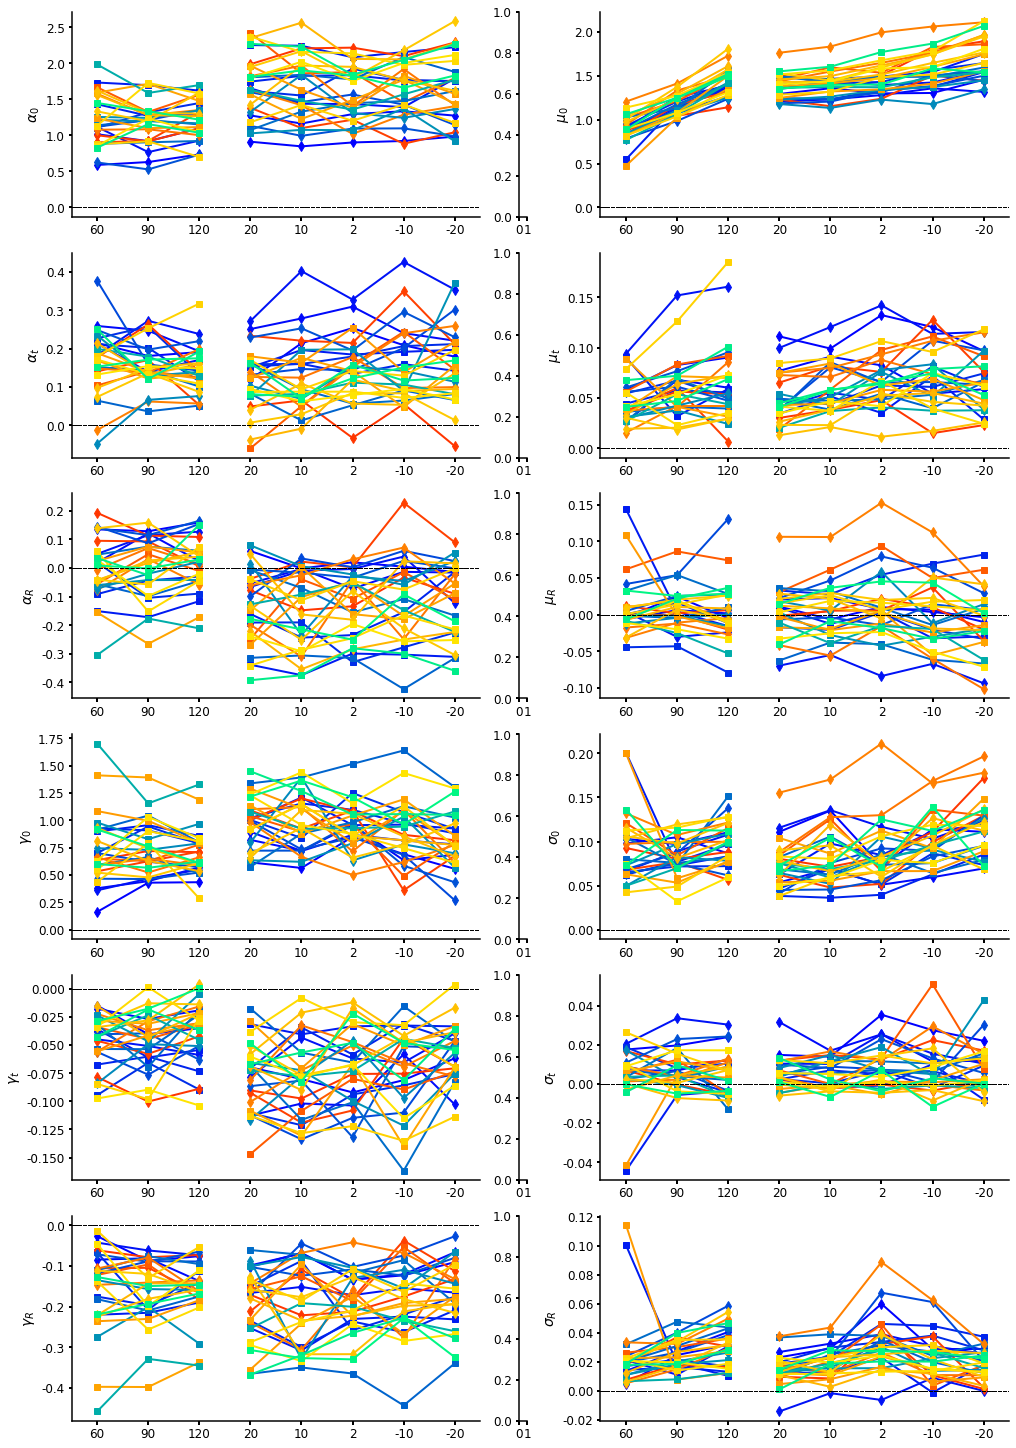

In [262]:
fig, axs = plt.subplots(6, 3, figsize=(14, 20), gridspec_kw={'width_ratios': [5, .1, 5]})
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_U$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_U$"]
ylimsIDLE = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_U$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_U$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .15], [-.05, .2], [-.05, .05], [-.025, .1], ]

varsIDLE = [alpha, alpha_t, alpha_U, gamma, gamma_t, gamma_U]
varsRUN = [mu, mu_t, mu_U, sigma, sigma_t, sigma_U, ]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(8))
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 7.5)
        # axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 2].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 2].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks(np.arange(8))
        axs[i, 2].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, 7.5)
        # axs[i, 2].set_ylim(ylim)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)
    


# LL ratio

LR test: -234.854 vs -208.636 with 1 less df
LR stat: 52.435, p=0.000 *
 
LR test: -209.965 vs -208.636 with 1 less df
LR stat: 2.657, p=0.103 
 
LR test: -210.894 vs -208.636 with 1 less df
LR stat: 4.516, p=0.034 *
 
LR test: -210.804 vs -208.636 with 1 less df
LR stat: 4.335, p=0.037 *
 
LR test: -239.425 vs -208.636 with 4 less df
LR stat: 61.578, p=0.000 *
 


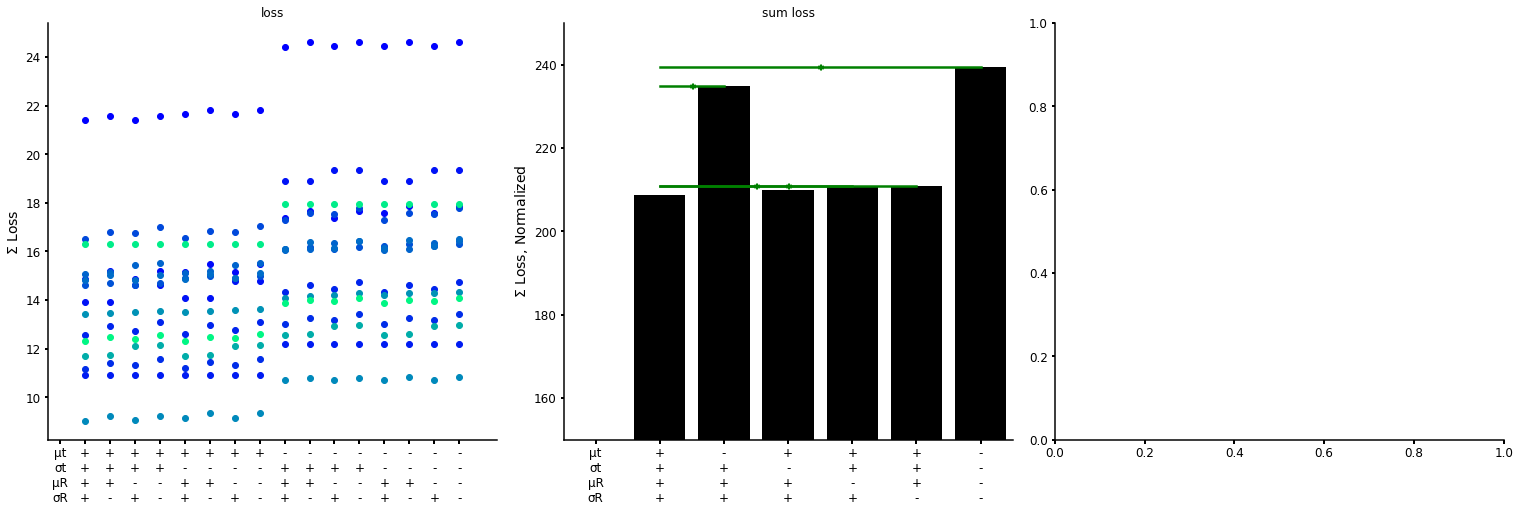

In [276]:
# likelihood ratio

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']


if os.path.exists("picklejar/ablationLossesCrossingTime.p"):
    ablation_losses = pickle.load(open("picklejar/ablationLossesCrossingTime.p", "rb"))
else:
    ablation_losses = {}
    for animal in intact:
        ablation_losses[animal] = {}
        for mu_t_fixed in [False, True]:
            for sigma_t_fixed in [False, True]:
                for mu_U_fixed in [False, True]:
                    for sigma_U_fixed in [False, True]:
                        number_of_params = 2  # mu, sigma
                        number_of_extra_params = mu_t_fixed+sigma_t_fixed+mu_U_fixed+sigma_U_fixed
                        loss = modelrun_fit(dataAllRUN[animal],
                                            f=modelrun_crit,
                                            mu_t_fixed=mu_t_fixed, 
                                            sigma_t_fixed=sigma_t_fixed, 
                                            mu_U_fixed=mu_U_fixed, 
                                            sigma_U_fixed=sigma_U_fixed, 
                                            N_params=number_of_params + (4 - number_of_extra_params),
                                            )[1]

                        ablation_losses[animal][(mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed)] = -loss

for animal in intact:
    axs[0].scatter(np.arange(16), [-l for l in ablation_losses[animal].values()], color=rat_markers[animal][0], label=animal)
    axs[0].set_title(f"loss")
    axs[0].set_ylabel(r'$\Sigma$ Loss')
    axs[0].set_xticks(np.arange(-1, 16))
    axs[0].set_xticklabels(dict_to_xticklabels(ablation_losses[animal], labels=['μt', 'σt', 'μR', 'σR']))
    # axs[0].set_ylim([80000, 140000])
    axs[0].set_xlim([-1.5, 16.5])

    for i, key in enumerate(the_keys_i_want):
        axs[1].bar(i+1, -np.sum([ablation_losses[animal][key] for animal in intact]), color='k', label='sum', )
    axs[1].set_title(f"sum loss")
    axs[1].set_ylabel(r'$\Sigma$ Loss, Normalized')
    axs[1].set_xticks(np.arange(7))
    axs[1].set_xticklabels(dict_to_xticklabels({k:ablation_losses[animal][k] for k in the_keys_i_want}, labels=['μt', 'σt', 'μR', 'σR']))
    axs[1].set_ylim([150, 250])
    axs[1].set_xlim([-.5, 6.5])
    axs[1].axhline(1, color='k', linestyle='--')


def LLratio_vs_complete(ablation_losses, keys, ax=None):
    if ax is None: ax = plt.gca()
    LL_sums = [np.sum([ablation_losses[animal][key] for animal in intact]) for key in keys]
    LL_complete = LL_sums[0]
    LL_reduced = LL_sums[1:]
    dParams = [np.sum(key) for key in keys][1:]

    for i, (reducted_model_loss, df) in enumerate(zip(LL_reduced, dParams)):
        LR = -2*(reducted_model_loss - LL_complete)
        p_val = stats.chi2.sf(LR, df)

        print(f"LR test: {reducted_model_loss:.3f} vs {LL_complete:.3f} with {df} less df")
        print(f"LR stat: {LR:.3f}, p={p_val:.3f} {'*' if p_val < .05 else ''}")
        print(" ")
    
        if p_val < .05:
            ax.plot((1, i+2), (-reducted_model_loss, -reducted_model_loss), color='g')
            ax.scatter((i+3)/2, -reducted_model_loss, color='g', marker=r'$\ast$')

LLratio_vs_complete(ablation_losses, the_keys_i_want, axs[1])
# pickle.dump(ablation_losses, open("picklejar/ablationLossesCrossingTime.p", "wb"))

LR test: -797.221 vs -784.402 with 1 less df
LR stat: 25.638, p=0.000 *
 
LR test: -792.833 vs -784.402 with 1 less df
LR stat: 16.863, p=0.000 *
 
LR test: -786.887 vs -784.402 with 1 less df
LR stat: 4.970, p=0.026 *
 
LR test: -804.750 vs -784.402 with 1 less df
LR stat: 40.697, p=0.000 *
 
LR test: -836.232 vs -784.402 with 4 less df
LR stat: 103.661, p=0.000 *
 


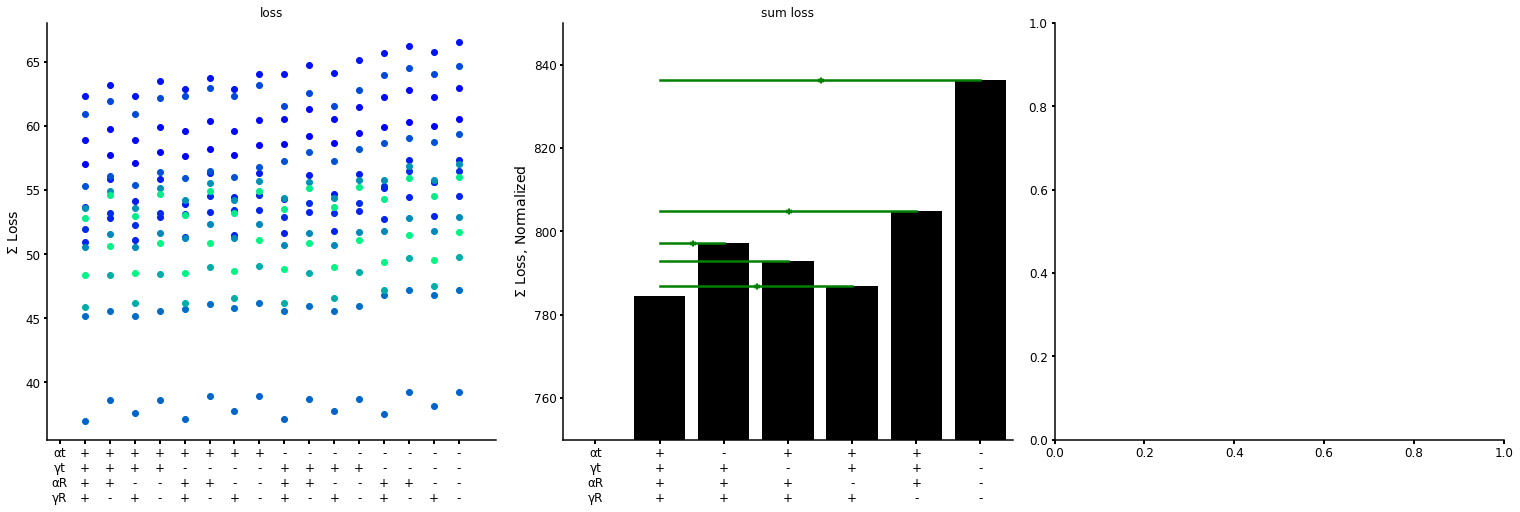

In [275]:
# likelihood ratio

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']


if os.path.exists("picklejar/ablationLossesIdleTime.p"):
    ablation_losses = pickle.load(open("picklejar/ablationLossesIdleTime.p", "rb"))
else:
    ablation_losses = {}
    for animal in animalList:
        ablation_losses[animal] = {}
        for alpha_t_fixed in [False, True]:
            for gamma_t_fixed in [False, True]:
                for alpha_U_fixed in [False, True]:
                    for gamma_U_fixed in [False, True]:
                        number_of_params = 2  # alpha, gamma
                        number_of_extra_params = alpha_t_fixed+gamma_t_fixed+alpha_U_fixed+gamma_U_fixed
                        loss = modelwald_fit(dataAllIDLE[animal], 
                                            f=model_crit,
                                            alpha_t_fixed=alpha_t_fixed, 
                                            gamma_t_fixed=gamma_t_fixed, 
                                            alpha_U_fixed=alpha_U_fixed, 
                                            gamma_U_fixed=gamma_U_fixed, 
                                            N_params=number_of_params + (4 - number_of_extra_params),
                                            )[1]

                        ablation_losses[animal][(alpha_t_fixed, gamma_t_fixed, alpha_U_fixed, gamma_U_fixed)] = -loss

for animal in intact:
    axs[0].scatter(np.arange(16), [-l for l in ablation_losses[animal].values()], color=rat_markers[animal][0], label=animal)
    axs[0].set_title(f"loss")
    axs[0].set_ylabel(r'$\Sigma$ Loss')
    axs[0].set_xticks(np.arange(-1, 16))
    axs[0].set_xticklabels(dict_to_xticklabels(ablation_losses[animal], labels=['αt', 'γt', 'αR', 'γR']))
    # axs[0].set_ylim([80000, 140000])
    axs[0].set_xlim([-1.5, 16.5])

    for i, key in enumerate(the_keys_i_want):
        axs[1].bar(i+1, -np.sum([ablation_losses[animal][key] for animal in intact]), color='k', label='sum', )
    axs[1].set_title(f"sum loss")
    axs[1].set_ylabel(r'$\Sigma$ Loss, Normalized')
    axs[1].set_xticks(np.arange(7))
    axs[1].set_xticklabels(dict_to_xticklabels({k:ablation_losses[animal][k] for k in the_keys_i_want}, labels=['αt', 'γt', 'αR', 'γR']))
    axs[1].set_ylim([750, 850])
    axs[1].set_xlim([-.5, 6.5])
    axs[1].axhline(1, color='k', linestyle='--')


LLratio_vs_complete(ablation_losses, the_keys_i_want, axs[1])
# pickle.dump(ablation_losses, open("picklejar/ablationLossesIdleTime.p", "wb"))

84
0.0


Text(0.5, 1.0, 'χ2(1) distribution')

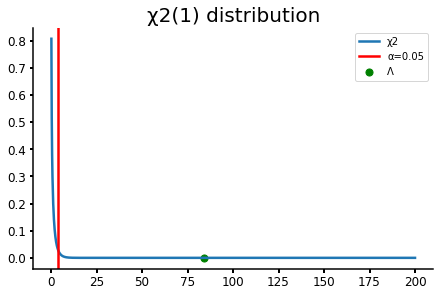

In [189]:
# log likelihood ratio test explained

ll_0, ll_1 = 1833, 1875 # given, the log-likelihoods of the nested models m_0, m_1
# log likelihood for m_0 (H_0) must be <= log likelihood of m_1 (H_1)
Λ = -2 * (ll_0 - ll_1)
print(Λ)
# 28.0
df = 1 # given the difference in dof
# compute the p-value
pvalue = 1 - stats.chi2(df).cdf(Λ) # since Λ follows χ2
print(pvalue)


α, df = 0.05, 1
x = np.linspace(0, 200, 1000)
plt.plot(x, stats.chi2(df).pdf(x), label='χ2')
plt.axvline(stats.chi2(df).ppf(1-α), color='red', label='α=0.05')
plt.scatter(Λ, 0, color='green', s=50, label='Λ')
plt.legend()
plt.title('χ2({}) distribution'.format(df), size=20)

# fit effort

In [7]:
realdist60 = {}
realdist90 = {}
realdist120= {}


# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])

# compute the mean running distance for each animal for each distance configuration
medianrealdist60 = {}
medianrealdist90 = {}
medianrealdist120 = {}

for animal in animalList:
    medianrealdist60[animal] = np.median(realdist60[animal]) / 100
    medianrealdist90[animal] = np.median(realdist90[animal]) / 100
    medianrealdist120[animal] = np.median(realdist120[animal]) / 100



In [8]:
def T_opt(D, vbelt, effort_sensitivity, power_effort, power_time=3):
    'dirty find optimal time for a given distance, belt speed, and reward size'
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

def effort_loss(params, *args):

    effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U, power_0 = params
    fit_params, realdist, N_bins, N_avg = args
    mu_0, mu_t, mu_U = fit_params
    S, M, L = realdist

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    params_distance = {"60": S, "90": M, "120": L, "20": L, "10": L, "2": L, "rev10": L, "rev20": L}
    params_vbelt = {"60": 0, "90": 0, "120": 0, "20": .2, "10": .1, "2": .02, "rev10": -.1, "rev20": -.2}

    loss = 0
    MU = {key: np.zeros((N_bins, N_avg)) for key in conds}
    EFFORT_SENSITIVITY = np.zeros((N_bins, N_avg))
    POWER = np.zeros((N_bins, N_avg))

    for cond in conds:
        for bin in range(N_bins):
            for avg in range(N_avg):
                MU[cond][bin, avg] = mu_0[cond] + bin*mu_t[cond] + avg*mu_U[cond]
                EFFORT_SENSITIVITY[bin, avg] = effort_sensitivity_0 + bin*effort_sensitivity_t + avg*effort_sensitivity_U
                POWER[bin, avg] = power_0

    for bin in range(N_bins):
        for avg in range(N_avg):
            # if bin == 0 and avg == 0:
                experimental_data = [MU[cond][bin, avg] for cond in conds]
                theoretical_data = [T_opt(params_distance[cond], params_vbelt[cond], effort_sensitivity=EFFORT_SENSITIVITY[bin, avg], power_effort=POWER[bin, avg]) for cond in conds]
                loss += np.sum((np.array(experimental_data) - np.array(theoretical_data))**2)

    return loss

def effort_fit(mu_0, mu_t, mu_U, 
                realdist60, realdist90, realdist120, 
                init=[12, 5, 1, 3], 
                f=effort_loss, N_bins=6, N_avg=4):
    
    params_init = np.array(init)

    res = minimize(f, params_init, 
                    args=((mu_0, mu_t, mu_U), (realdist60, realdist90, realdist120, ), N_bins, N_avg),
                    method='nelder-mead', options={'xatol': 1e-9}, 
                    # bounds=[(0, 60), (0, 20), (-10, 10), (1, 4)]
                    )
    return res.x, res.fun

animal = 'RatF41'
effort_fit(mu[animal], mu_t[animal], mu_U[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


(array([54.01500786, 11.27017786,  0.79683045,  2.67933404]),
 11.222565802778572)

In [310]:
effort_sensitivity_0 = {}
effort_sensitivity_t = {}
effort_sensitivity_U = {}
power_0 = {}
loss_effort_fit = {}

for animal in animalList:
    (effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal]), loss_effort_fit[animal] = effort_fit(mu[animal], mu_t[animal], mu_U[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])
    print(animal, effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal], loss_effort_fit[animal])

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


RatF00 8.750695934751331 6.160031044747811 1.0729759724835572 2.10687060932287 0.7265494567446581
RatF01 10.420143656811938 3.534113233308519 0.9244366647548721 1.8812258277831624 1.3468832554251158
RatF02 13.512953315250323 7.427722705666087 -2.6228186787190815 2.0836302078639486 2.250294441604214
RatM00 11.90239776690201 2.931802238115846 1.2439734500996684 2.480711321097187 2.6239820383331245
RatM01 9.551820812874873 3.6169101462443884 1.1757029035260445 3.01612489387255 1.8796749930684304
RatM02 9.40261754548387 3.341080778774607 1.1772237175851723 2.649720427638229 3.059440305620921
RatF30 15.453225062662277 2.6137527287463436 1.0944230293442039 3.1026706310995005 5.643382644751569
RatF31 6.5721302484179445 3.4963095226667438 1.4739086901834972 2.7623731316171325 5.664907819024593
RatF32 5.487428677823306 4.287121394995934 3.080588705365639 3.107773762447777 2.0700438635739147
RatF33 6.410641442586926 3.294159744082033 1.3603093921635616 2.507505843872223 2.015222917034247
RatM30 

In [312]:
# pickle.dump((effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U), open('picklejar/effort_fit.p', 'wb'))
pickle.dump((effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U, power_0), open('picklejar/effort_sensitivity_fit.p', 'wb'))
# effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U = pickle.load(open('picklejar/effort_fit.p', 'rb'))

RatF00 8.750695934751331 6.160031044747811 1.0729759724835572 2.10687060932287
RatF01 10.420143656811938 3.534113233308519 0.9244366647548721 1.8812258277831624
RatF02 13.512953315250323 7.427722705666087 -2.6228186787190815 2.0836302078639486
RatM00 11.90239776690201 2.931802238115846 1.2439734500996684 2.480711321097187
RatM01 9.551820812874873 3.6169101462443884 1.1757029035260445 3.01612489387255
RatM02 9.40261754548387 3.341080778774607 1.1772237175851723 2.649720427638229
RatF30 15.453225062662277 2.6137527287463436 1.0944230293442039 3.1026706310995005
RatF31 6.5721302484179445 3.4963095226667438 1.4739086901834972 2.7623731316171325
RatF32 5.487428677823306 4.287121394995934 3.080588705365639 3.107773762447777
RatF33 6.410641442586926 3.294159744082033 1.3603093921635616 2.507505843872223
RatM30 17.512289649924448 10.506803434895488 7.7287020083202345 3.0555159797488667
RatM31 15.74859297950476 2.3425960533214454 -1.8126384001879097 2.1489782069288905
RatM32 16.008467052246036 

Text(0, 0.5, 'effort power parameter')

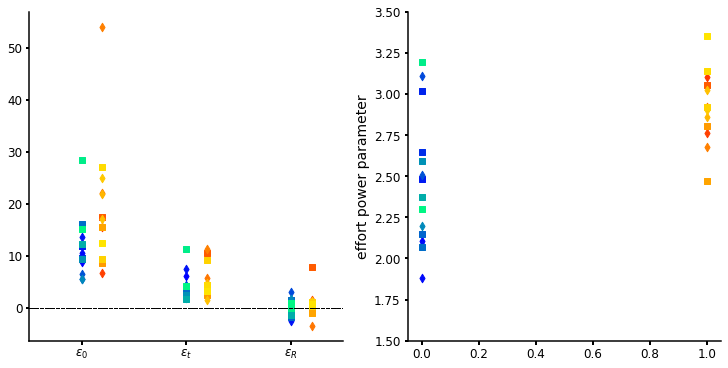

In [318]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ylabels = [r'$\effort_sensitivity_0$', r"$\effort_sensitivity_t$", r"$\effort_sensitivity_U$"]
ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15],]


effort_sensitivity_0_intact = []
effort_sensitivity_t_intact = []
effort_sensitivity_U_intact = []
power_0_intact = []

effort_sensitivity_0_lesion = []
effort_sensitivity_t_lesion = []
effort_sensitivity_U_lesion = []
power_0_lesion = []

for animal in animalList:
    if animal in intact:
        x = np.arange(3)
        effort_sensitivity_0_intact.append(effort_sensitivity_0[animal])
        effort_sensitivity_t_intact.append(effort_sensitivity_t[animal])
        effort_sensitivity_U_intact.append(effort_sensitivity_U[animal])
        power_0_intact.append(power_0[animal])

    else:
        x = np.arange(3) + .2
        effort_sensitivity_0_lesion.append(effort_sensitivity_0[animal])
        effort_sensitivity_t_lesion.append(effort_sensitivity_t[animal])
        effort_sensitivity_U_lesion.append(effort_sensitivity_U[animal])
        power_0_lesion.append(power_0[animal])

    print(animal, effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal])
    axs[0].scatter(x,  [effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    axs[0].set_title(f"")
    axs[0].set_xticks(np.arange(3))
    axs[0].set_xticklabels(ylabels)
    axs[0].set_xlim(-.5, 2.5)
    # axs.set_ylim(ylim)
    axs[0].axhline(0, color='black', linestyle='--', linewidth=1)

    x = 0 if animal in intact else 1
    axs[1].scatter(x, power_0[animal], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    axs[1].set_ylim(1.5, 3.5)

# axs[0].set_xlabel("effort sensibility parameter")

axs[1].set_ylabel("effort power parameter")

In [319]:
perm = exact_mc_perm_test(effort_sensitivity_0_intact, effort_sensitivity_0_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(effort_sensitivity_t_intact, effort_sensitivity_t_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(effort_sensitivity_U_intact, effort_sensitivity_U_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(power_0_intact, power_0_lesion, 10000)
print(f'p = {perm}')


p = 0.0073
p = 0.1418
p = 0.8449
p = 0.0063


In [320]:
np.median(power_0_intact)

2.375843241433299

In [317]:
np.median(power_0_lesion)

2.9205782944291547

# power time free

In [52]:
# def T_opt(D, vbelt, effort_sensitivity, power_effort, power_time=3):
#     'dirty find optimal time for a given distance, belt speed, and reward size'
#     T = np.linspace(0.0, 2.5, 1000)
#     vmax = (D - vbelt * T) / (T)
#     cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
#     Topt = T[np.nanargmin(cost)]
#     return Topt

def T_opt(D, vbelt, effort_sensitivity, power_effort, power_time=3):
    'dirty find optimal time for a given distance, belt speed, and reward size'
    T = np.linspace(0.0, 2.5, 1000)
    A=5
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + A-A/(1 + T*power_time)
    Topt = T[np.nanargmin(cost)]
    return Topt

def effort_loss(params, *args):

    effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_U, power_0, power_time = params
    fit_params, realdist, N_bins, N_avg = args
    mu_0, mu_t, mu_U = fit_params
    S, M, L = realdist

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    params_distance = {"60": S, "90": M, "120": L, "20": L, "10": L, "2": L, "rev10": L, "rev20": L}
    params_vbelt = {"60": 0, "90": 0, "120": 0, "20": .2, "10": .1, "2": .02, "rev10": -.1, "rev20": -.2}

    loss = 0
    MU = {key: np.zeros((N_bins, N_avg)) for key in conds}
    EFFORT_SENSITIVITY = np.zeros((N_bins, N_avg))
    POWER = np.zeros((N_bins, N_avg))
    POWER_TIME = np.zeros((N_bins, N_avg))

    for cond in conds:
        for bin in range(N_bins):
            for avg in range(N_avg):
                MU[cond][bin, avg] = mu_0[cond] + bin*mu_t[cond] + avg*mu_U[cond]
                EFFORT_SENSITIVITY[bin, avg] = effort_sensitivity_0 + bin*effort_sensitivity_t + avg*effort_sensitivity_U
                POWER[bin, avg] = power_0
                POWER_TIME[bin, avg] = power_time

    for bin in range(N_bins):
        for avg in range(N_avg):
            # if bin == 0 and avg == 0:
                experimental_data = [MU[cond][bin, avg] for cond in conds]
                theoretical_data = [T_opt(params_distance[cond], params_vbelt[cond], effort_sensitivity=EFFORT_SENSITIVITY[bin, avg], 
                                          power_effort=POWER[bin, avg], power_time=POWER_TIME[bin, avg]) for cond in conds]
                loss += np.sum((np.array(experimental_data) - np.array(theoretical_data))**2)

    return loss

def effort_fit(mu_0, mu_t, mu_U, 
                realdist60, realdist90, realdist120, 
                init=[12, 5, 1, 3, 3], 
                f=effort_loss, N_bins=6, N_avg=4):
    
    params_init = np.array(init)

    res = minimize(f, params_init, 
                    args=((mu_0, mu_t, mu_U), (realdist60, realdist90, realdist120, ), N_bins, N_avg),
                    method='nelder-mead', options={'xatol': 1e-9}, 
                    # bounds=[(0, 60), (0, 20), (-10, 10), (1, 4)]
                    )
    return res.x, res.fun

animal = 'RatF41'
effort_fit(mu[animal], mu_t[animal], mu_U[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


(array([4.86864725, 8.04476738, 0.75822843, 7.25422406, 0.02629878]),
 19.975171442867648)

In [53]:
effort_sensitivity_0 = {}
effort_sensitivity_t = {}
effort_sensitivity_U = {}
power_0 = {}
power_time = {}
loss_effort_fit = {}

for animal in animalList:
    (effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal], power_time[animal]), loss_effort_fit[animal] = effort_fit(mu[animal], mu_t[animal], mu_U[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])
    print(animal, effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal], power_time[animal], loss_effort_fit[animal])

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


RatF00 3.6387320619331263 8.383469435742658 -0.9379922055803493 13.768487843283646 0.07798041653849912 24.54678218511859
RatF01 8.875822320568453 10.038443968688028 -2.650780103022667 18.499072863985226 0.058519383622127386 25.240491188035595
RatF02 15.440369412867359 3.5186424423523754 0.18119727899366195 8.396276823451387 -0.6456669258435004 17.073066835293552
RatM00 0.17244051812412398 0.045505556186504065 6.148365322001602 5.053727909861308 18.968983880089386 115.69793544974809
RatM01 23.289665795729512 2.537534539221964 0.02198829569964328 3.220110370291179 2.6370713479667662 167.81618588664747
RatM02 103.14681175931311 170.59225694061132 -6.905228723758725 22.58791521566534 2.172075088834857 20.815106003807816
RatF30 31.66742624185272 5.005753519048997 -5.1057015439695554 16.284701857400712 0.030390494451415874 17.715576172646838
RatF31 4.36718475688263 2.503549749760853 -1.1169592422700498 12.5284536404684 2.9441430177111854 24.13149431691961
RatF32 7.337229257395331 8.925971918

RatF00 3.6387320619331263 8.383469435742658 -0.9379922055803493 13.768487843283646 0.07798041653849912
RatF01 8.875822320568453 10.038443968688028 -2.650780103022667 18.499072863985226 0.058519383622127386
RatF02 15.440369412867359 3.5186424423523754 0.18119727899366195 8.396276823451387 -0.6456669258435004
RatM00 0.17244051812412398 0.045505556186504065 6.148365322001602 5.053727909861308 18.968983880089386
RatM01 23.289665795729512 2.537534539221964 0.02198829569964328 3.220110370291179 2.6370713479667662
RatM02 103.14681175931311 170.59225694061132 -6.905228723758725 22.58791521566534 2.172075088834857
RatF30 31.66742624185272 5.005753519048997 -5.1057015439695554 16.284701857400712 0.030390494451415874
RatF31 4.36718475688263 2.503549749760853 -1.1169592422700498 12.5284536404684 2.9441430177111854
RatF32 7.337229257395331 8.925971918137936 -1.647845898354137 14.821569910418605 0.07206130160468695
RatF33 8.518422023225744 9.210787716076911 -2.1875637872162184 17.873169812128268 0.0

Text(0, 0.5, 'effort power parameter')

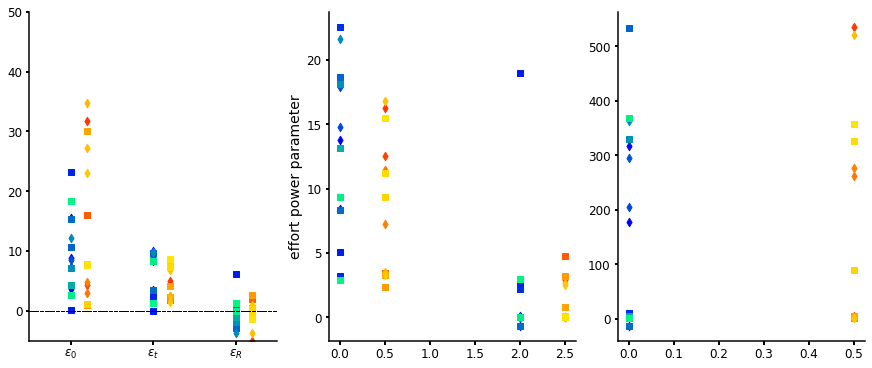

In [66]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
ylabels = [r'$\effort_sensitivity_0$', r"$\effort_sensitivity_t$", r"$\effort_sensitivity_U$"]
ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15],]


effort_sensitivity_0_intact = []
effort_sensitivity_t_intact = []
effort_sensitivity_U_intact = []
power_0_intact = []
power_time_intact = []
ratio_intact = []

effort_sensitivity_0_lesion = []
effort_sensitivity_t_lesion = []
effort_sensitivity_U_lesion = []
power_0_lesion = []
power_time_lesion = []
ratio_lesion = []

for animal in animalList:
    if animal in intact:
        x = np.arange(3)
        effort_sensitivity_0_intact.append(effort_sensitivity_0[animal])
        effort_sensitivity_t_intact.append(effort_sensitivity_t[animal])
        effort_sensitivity_U_intact.append(effort_sensitivity_U[animal])
        power_0_intact.append(power_0[animal])
        power_time_intact.append(power_time[animal])
        ratio_intact.append(power_0[animal]/power_time[animal])
        # ratio_intact.append(power_time[animal]/power_0[animal])

    else:
        x = np.arange(3) + .2
        effort_sensitivity_0_lesion.append(effort_sensitivity_0[animal])
        effort_sensitivity_t_lesion.append(effort_sensitivity_t[animal])
        effort_sensitivity_U_lesion.append(effort_sensitivity_U[animal])
        power_0_lesion.append(power_0[animal])
        power_time_lesion.append(power_time[animal])
        ratio_lesion.append(power_0[animal]/power_time[animal])
        # ratio_lesion.append(power_time[animal]/power_0[animal])

    print(animal, effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal], power_0[animal], power_time[animal])
    axs[0].scatter(x,  [effort_sensitivity_0[animal], effort_sensitivity_t[animal], effort_sensitivity_U[animal]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    axs[0].set_title(f"")
    axs[0].set_xticks(np.arange(3))
    axs[0].set_xticklabels(ylabels)
    axs[0].set_xlim(-.5, 2.5)
    axs[0].set_ylim(-5, 50)
    axs[0].axhline(0, color='black', linestyle='--', linewidth=1)

    x = 0 if animal in intact else .5
    axs[1].scatter(x, power_0[animal], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    axs[1].scatter(2+x, power_time[animal], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    # axs[1].set_ylim(1, 10)

    axs[2].scatter(x, power_0[animal]/power_time[animal], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])

# axs[0].set_xlabel("effort sensibility parameter")

axs[1].set_ylabel("effort power parameter")

In [67]:
perm = exact_mc_perm_test(effort_sensitivity_0_intact, effort_sensitivity_0_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(effort_sensitivity_t_intact, effort_sensitivity_t_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(effort_sensitivity_U_intact, effort_sensitivity_U_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(power_0_intact, power_0_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(power_time_intact, power_time_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(ratio_intact, ratio_lesion, 10000)
print(f'p = {perm}')

mann = stats.mannwhitneyu(ratio_intact, ratio_lesion)
print(f'p = {mann.pvalue}')

p = 0.8449
p = 0.4381
p = 0.1729
p = 0.2926
p = 0.4411
p = 1.0
p = 0.8178378992551184


# fit example session

In [321]:
animal='RatM00'
session='RatM00_2021_07_22_16_13_03'

data_run = prepare_data_running_times(sequence, [animal], [session])
data_idle = prepare_data_idle_times(sequence, [animal], [session])

In [322]:
# fig, axs = plt.subplots(6, 3, figsize=(12, 20), gridspec_kw={'width_ratios': [5, 5, 2]})
ylabels = [r'$\mu_0$', r"$\mu_t$", r"$\mu_U$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_U$"]
ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15], [-.05, .2], [-.05, .05], [-.025, .1], ]
mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = False, False, False, False
# mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = False, True, True, False
# mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = False, False, True, False
# mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = True, True, True, True

(ex_mu, ex_sigma, ex_mu_t, ex_sigma_t, ex_mu_U, ex_sigma_U), loss_run = modelrun_fit(data_run[animal])
(ex_alpha, _, ex_gamma, ex_alpha_t, _, ex_gamma_t, ex_alpha_U, _, ex_gamma_U), loss_idle = modelwald_fit(data_idle[animal])

print((ex_mu, ex_mu_t, ex_mu_U, ex_sigma, ex_sigma_t, ex_sigma_U), loss_run)
print((ex_alpha, ex_alpha_t, ex_alpha_U, ex_gamma, ex_gamma_t, ex_gamma_U), loss_idle)

# pickle.dump((ex_mu, ex_mu_t, ex_mu_U, ex_sigma, ex_sigma_t, ex_sigma_U), open("picklejar/crossing_time_fit_example_session.p", 'wb'))
# pickle.dump((ex_alpha, ex_alpha_t, ex_alpha_U, ex_gamma, ex_gamma_t, ex_gamma_U), open("picklejar/idle_time_fit_example_session.p", 'wb'))

(1.364056803789173, 0.06320540890720386, -0.004086011765415236, 0.07769265351251081, -0.0032982158845333205, 0.014050822653490853) -1.9323169041602763
(1.6749019366658602, 0.32652823486284416, -0.05871907890528583, 1.0650098929093814, -0.055303904901337214, -0.24711719272673832) 56.99993083613219


(0.0, 2.0)

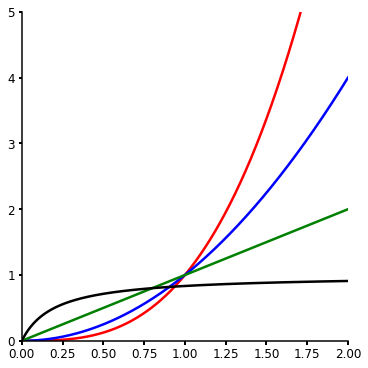

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x = np.linspace(0, 2, 1000)

ycube = x**3
ysquare = x**2
ylinear = x

A = 1
b = 5
y = A- A / (1 + b*x)




ax.plot(x, ycube, 'r', label='power=3')
ax.plot(x, ysquare, 'b', label='power=2')
ax.plot(x, ylinear, 'g', label='power=1')
ax.plot(x, y, 'k', label='power=0')

ax.set_ylim(0, 5)
ax.set_xlim(0, 2)